# **Introductions**

To continue with 3.9 and finish shap and dpd to select a few features from each categories.

In [ ]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib
import matplotlib.pyplot as plt
import os
import io
import geopandas as gpd
import seaborn as sns
import statsmodels.api as sm
import datetime
import shap
import geopandas as gpd
from shapely.geometry import Point
from scipy import stats
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import mutual_info_regression
from sklearn.inspection import PartialDependenceDisplay
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeRegressor

# suppress warning
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

# **Step 1: get the data**

In [ ]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
file_path = "/content/drive/My Drive/X999/bbl_evictions_311_svi_normal_times_analysis.csv"

In [ ]:
df_raw = pd.read_csv(file_path)

In [ ]:
df = df_raw.copy()

# **Step 2: adjust the data for analysis**

In [ ]:
type(df.geometry[0])
# while saving the files, the geometry part has been corrupted to strings, which is normal, just need to redo to geopanda.

str

In [ ]:
geometry = [Point(xy) for xy in zip(df['longitude'], df['latitude'])]
gdf = gpd.GeoDataFrame(df, geometry=geometry)
gdf.set_crs(epsg=4326, inplace=True)
# did not run this one, because this df is too big, but using longitude and laititude as the geo features should 
# be sufficient

In [ ]:
df.columns, df.shape

(Index(['Unnamed: 0', 'primary_key', 'bbl', 'court_index_number',
        'docket_number', 'eviction_address', 'eviction_apartment_number',
        'executed_date', 'borough', 'zipcode',
        ...
        'total_complaints', 'building_age', 'style_ordinal', 'style_freq',
        'style_label', 'building_category_ordinal', 'building_category_freq',
        'building_category_le', 'age_bin', 'age_group'],
       dtype='object', length=102),
 (66397, 102))

In [ ]:
df.svi_quartile.unique()
# these are strings, and will not work with the analysis.

array(['Q3', 'Q4 (High)', 'Q2', 'Q1 (Low)'], dtype=object)

In [ ]:
df.svi_quartile = df.svi_quartile.str.extract(r'Q(\d)').astype(int)

In [ ]:
df.svi_quartile.unique(), df.svi_quartile[0].dtype

(array([3, 4, 2, 1]), dtype('int64'))

In [ ]:
svi_vars = ['rpl_theme1', 'rpl_theme2', 'rpl_theme3', 'rpl_theme4', 'rpl_themes', 'ep_pov150', 'ep_unemp', 'ep_nohsdp', 'ep_uninsur',
  'ep_age65', 'ep_age17', 'ep_disabl', 'ep_limeng', 'ep_noveh', 'ep_crowd', 'ep_hburd', 'ep_afam', 'ep_hisp', 'ep_asian', 'ep_aian',
  'ep_nhpi', 'ep_twomore', 'ep_otherrace', 'ep_minrty', 'ep_white', 'svi_quartile']

In [ ]:
new_building_vars = ['numfloors', 'building_category_ordinal', 'unitsres', 'bldgarea', 'building_type', 'is_condo', 'is_llc',
  'style_ordinal', 'building_age', 'floor_category', 'size_quartile', 'building_size_category', 'residential_units_category']

In [ ]:
complaints_vars = ['air_quality', 'animal_issues', 'appliances', 'building_exterior', 'doors_windows', 'electrical_issues',
  'elevator_issues', 'floors_stairs', 'general_complaints', 'graffiti_posting', 'heat_hot_water', 'homeless_issues', 'noise_complaints',
  'other_issues', 'pest_issues', 'plumbing_issues', 'police_matters', 'public_nuisance',
  'safety_concerns', 'sanitation_issues', 'walls_ceilings','total_complaints']

In [36]:
df.month_year.unique()

array(['2024-12', '2024-03', '2024-08', '2018-10', '2019-08', '2017-05',
       '2017-10', '2017-09', '2023-01', '2018-12', '2018-11', '2017-01',
       '2017-07', '2018-04', '2019-05', '2017-04', '2023-05', '2018-07',
       '2019-04', '2018-06', '2023-06', '2017-06', '2024-05', '2017-08',
       '2019-10', '2018-05', '2023-10', '2018-09', '2019-01', '2019-12',
       '2018-02', '2019-06', '2019-09', '2019-11', '2023-04', '2018-03',
       '2019-03', '2018-01', '2017-03', '2017-11', '2017-02', '2024-07',
       '2024-04', '2018-08', '2024-02', '2019-07', '2019-02', '2017-12',
       '2024-06', '2024-09', '2023-02', '2024-11', '2023-07', '2023-11',
       '2024-01', '2023-08', '2023-09', '2024-10', '2023-12', '2023-03'],
      dtype=object)

In [76]:
df['month'] = df['month_year'].str[-2:]
# they are strings
df.month = df.month.astype(int)

In [56]:
df.borough.unique()

array(['BROOKLYN', 'BRONX', 'STATEN ISLAND', 'MANHATTAN', 'QUEENS'],
      dtype=object)

In [45]:
borough_map = {
    'MANHATTAN': 1,
    'BRONX': 2,
    'BROOKLYN': 3,
    'QUEENS': 4,
    'STATEN ISLAND': 5
}

In [46]:
df['borough_int'] = df['borough'].map(borough_map)

In [77]:
geo_temporal_vars = ['longitude','latitude', 'borough_int', 'year', 'month']
# new feature group

In [80]:
all_vars = svi_vars + new_building_vars + complaints_vars + geo_temporal_vars
# since we are already here.

In [ ]:
# df.svi_group.unique()

# **Step 3: the training and testing data and build the RFR models**

In [ ]:
X_svi = df[svi_vars]
y_svi = df['average_year_eviction_count']
X_building = df[new_building_vars]
y_building = df['average_year_eviction_count']
X_311 = df[complaints_vars]
y_311 = df['average_year_eviction_count']

In [78]:
X_gt = df[geo_temporal_vars]
y_gt = df['average_year_eviction_count']

In [81]:
X_all = df[all_vars]
y_all = df['average_year_eviction_count']

In [ ]:
X_train_svi, X_test_svi, y_train_svi, y_test_svi = train_test_split(X_svi, y_svi, test_size=0.2, random_state=42)

In [ ]:
X_train_building, X_test_building, y_train_building, y_test_building = train_test_split(X_building, y_building, test_size=0.2, random_state=42)

In [ ]:
X_train_311, X_test_311, y_train_311, y_test_311 = train_test_split(X_311, y_311, test_size=0.2, random_state=42)

In [82]:
X_train_all, X_test_all, y_train_all, y_test_all = train_test_split(X_all, y_all, test_size=0.2, random_state=42)

In [79]:
X_train_gt, X_test_gt, y_train_gt, y_test_gt = train_test_split(X_gt, y_gt, test_size=0.2, random_state=42)

In [ ]:
model_rfr_svi = RandomForestRegressor(n_estimators=100, random_state=42)
model_rfr_svi.fit(X_train_svi, y_train_svi)

RandomForestRegressor(random_state=42)

In [ ]:
model_rfr_311 = RandomForestRegressor(n_estimators=100, random_state=42)
model_rfr_311.fit(X_train_311, y_train_311)

RandomForestRegressor(random_state=42)

In [ ]:
model_rfr_building = RandomForestRegressor(n_estimators=100, random_state=42)
model_rfr_building.fit(X_train_building, y_train_building)

RandomForestRegressor(random_state=42)

In [85]:
model_rfr_all = RandomForestRegressor(n_estimators=100, random_state=42)
model_rfr_all.fit(X_train_all, y_train_all)

RandomForestRegressor(random_state=42)

In [83]:
model_rfr_gt = RandomForestRegressor(n_estimators=100, random_state=42)
model_rfr_gt.fit(X_train_gt, y_train_gt)

RandomForestRegressor(random_state=42)

# **Step 4: Running tests and geting resulst**

PermutationExplainer explainer: 501it [02:54,  2.76it/s]


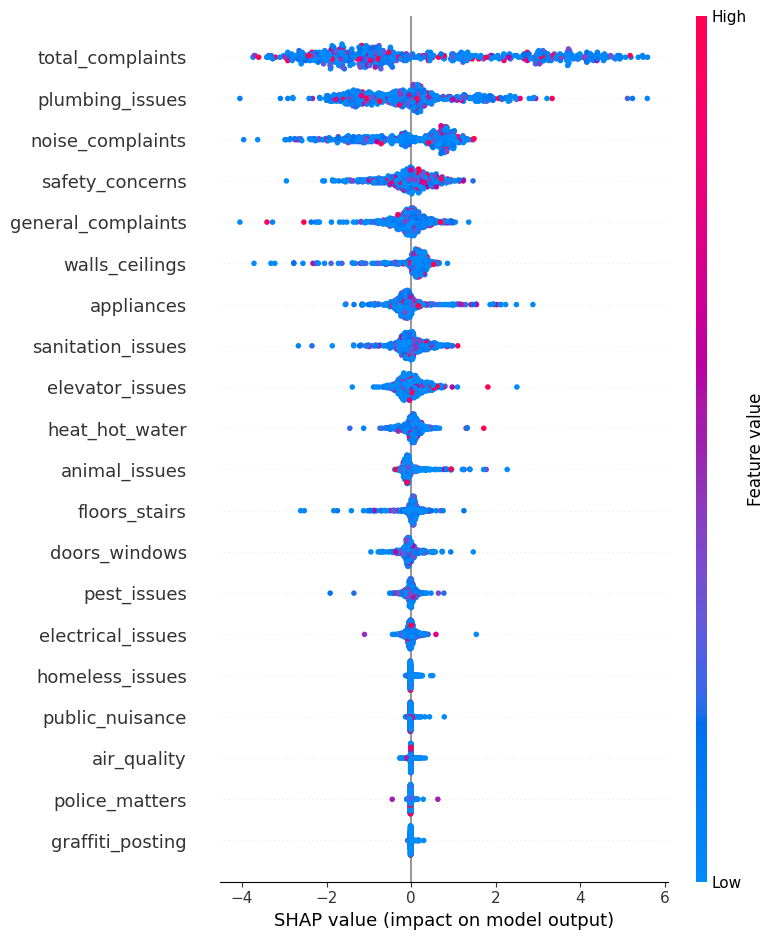

In [ ]:
# model.predict instead of model, faster
explainer = shap.Explainer(model_rfr_311.predict, X_311)
# need to only select the first few hundreds of samples to run
shap_values = explainer.shap_values(X_311.sample(n=500))
shap.summary_plot(shap_values, X_311.sample(n=500))

PermutationExplainer explainer: 501it [02:16,  3.40it/s]


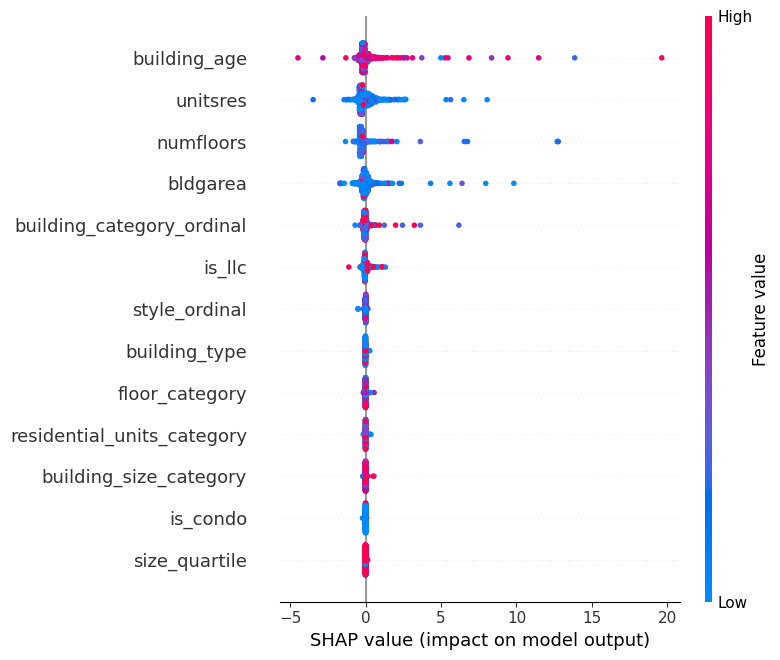

In [ ]:
# model.predict instead of model, faster
explainer = shap.Explainer(model_rfr_building.predict, X_building)
shap_values = explainer.shap_values(X_building.sample(n=500))
shap.summary_plot(shap_values, X_building.sample(n=500))

PermutationExplainer explainer: 501it [01:45,  4.31it/s]


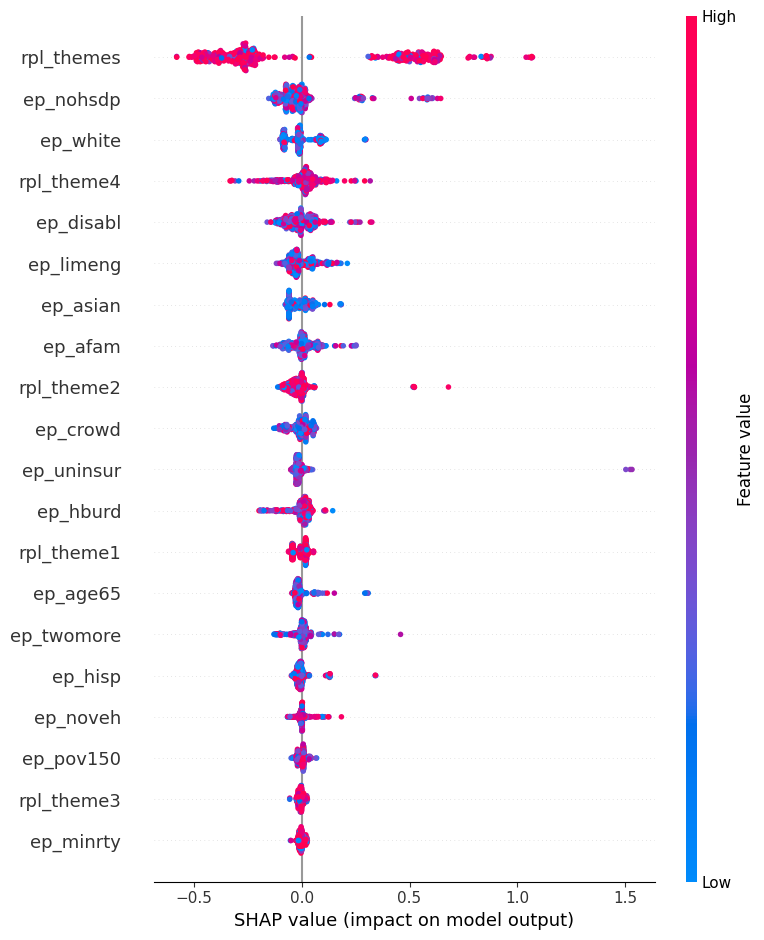

In [ ]:
# model.predict instead of model, faster
explainer = shap.Explainer(model_rfr_svi.predict, X_svi)
shap_values = explainer.shap_values(X_svi.sample(n=500))
shap.summary_plot(shap_values, X_svi.sample(n=500))

In [73]:
print(shap.__version__)

0.47.1


ExactExplainer explainer: 501it [00:56,  7.23it/s]


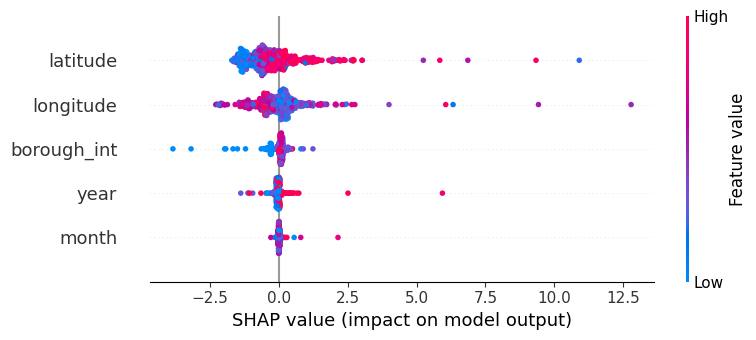

In [88]:
X_sample = X_gt.sample(n=500)
explainer = shap.Explainer(model_rfr_gt.predict, X_gt)
shap_values = explainer(X_sample)
shap.summary_plot(shap_values, X_sample)
# geo matters more than temporal
# running geo feature group test

In [90]:
X_sample = X_gt.sample(n=500, random_state=0)
shap_values = explainer(X_sample)
mean_abs_shap = np.abs(shap_values.values).mean(axis=0)
shap_feature_importance = pd.Series(mean_abs_shap, index=X_sample.columns)
top_features = shap_feature_importance.sort_values(ascending=False)
top_features.head(10)

ExactExplainer explainer: 501it [00:58,  7.15it/s]


,0
latitude,0.877219
longitude,0.656468
borough_int,0.171970
year,0.071106
month,0.022357


PermutationExplainer explainer: 501it [07:13,  1.13it/s]


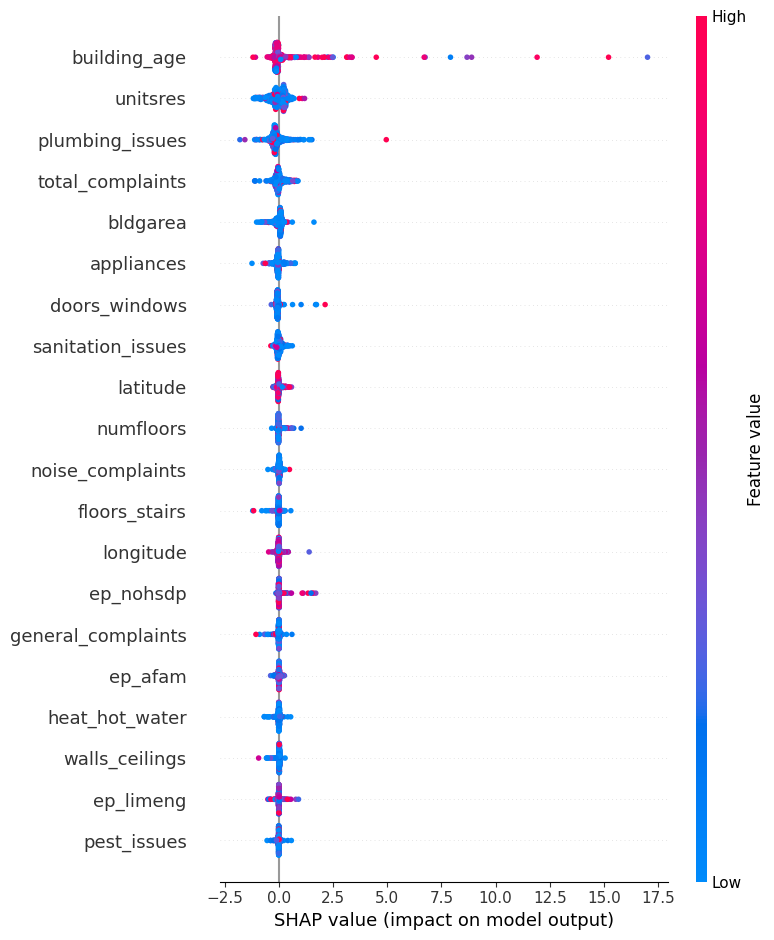

In [91]:
# model.predict instead of model, faster
explainer = shap.Explainer(model_rfr_all.predict, X_all)
explainer = shap.Explainer(model_rfr_all.predict, X_all)
shap_values = explainer.shap_values(X_all.sample(n=500))
shap.summary_plot(shap_values, X_all.sample(n=500))

In [93]:
X_sample = X_all.sample(n=500, random_state=0)
mean_abs_shap = np.abs(shap_values).mean(axis=0)
shap_feature_importance = pd.Series(mean_abs_shap, index=X_sample.columns)
top_features = shap_feature_importance.sort_values(ascending=False)
top_features.head(20)
# an updated list

,0
building_age,0.407389
unitsres,0.256477
plumbing_issues,0.246408
total_complaints,0.146631
bldgarea,0.112454
appliances,0.097650
doors_windows,0.086469
sanitation_issues,0.072450
latitude,0.060535
numfloors,0.052635


In [99]:
# list(top_features.index)

In [102]:
# updated top 20:
top_20 = ['building_age', 'unitsres', 'plumbing_issues', 'total_complaints', 'bldgarea', 'appliances', 'doors_windows',
 'sanitation_issues', 'latitude', 'numfloors', 'noise_complaints', 'floors_stairs', 'longitude', 'ep_nohsdp', 'general_complaints',
 'ep_afam', 'heat_hot_water', 'walls_ceilings', 'ep_limeng', 'pest_issues']

## **In summary, given all analysis (linear, mis, rfr, dt, and shap). We will work with these features in the next notebooks: (these are from seperate analysis)**

Building features: \
bldgarea – strongest across MI, correlation, and feature importance. Larger buildings are associated with more evictions. \

building_age – older buildings tend to have higher eviction rates, seen in decision tree and partial dependence plots. \

unitsres – number of residential units is consistently predictive, especially in mutual information and feature importance. \

numfloors – more floors often correlate with higher eviction counts. \

is_llc – LLC-owned buildings show a subtle but consistent positive impact on eviction rate in SHAP/PDP plots. \



311 features: \

plumbing_issues – first feature across almost all model types and SHAP plots.

total_complaints – high predictive power across correlation, mutual info, and feature importances.

noise_complaints – strong predictor of eviction activity; captures tenant distress or instability.

doors_windows – often in the top 5 in feature importance and decision tree visualizations.

heat_hot_water – partial dependence plots show steep rises in eviction risk at low service levels.

(runner-ups: sanitation_issues, walls_ceilings, general_complaints)

svi features: \

rpl_themes – composite SVI score, ranked #1 in multiple charts.

ep_uninsur – percentage of uninsured population is consistently high in importance.

ep_nohsdp – % of without high school diploma is also strongly predictive.

rpl_theme2 – socioeconomic vulnerability (subset theme of rpl_themes) is significant.

ep_hisp / ep_limeng / ep_age65 – tied in importance across methods, depending on model type.